### Boring stuff

In [14]:
from models_v2 import *

In [15]:
chosen_one = deit_small_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)

In [16]:
chosen_one

vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,

In [17]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader


In [18]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to match model input
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [19]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [20]:
train_dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [21]:
image = train_dataset[0][0]
image.shape

torch.Size([3, 384, 384])

In [22]:
image

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7137, 0.7137, 0.7137],
         [1.0000, 1.0000, 1.0000,  ..., 0.7137, 0.7137, 0.7137],
         [1.0000, 1.0000, 1.0000,  ..., 0.7137, 0.7137, 0.7137],
         ...,
         [0.3412, 0.3412, 0.3412,  ..., 0.5412, 0.5412, 0.5412],
         [0.3412, 0.3412, 0.3412,  ..., 0.5412, 0.5412, 0.5412],
         [0.3412, 0.3412, 0.3412,  ..., 0.5412, 0.5412, 0.5412]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
         [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
         [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7608, 0.7608],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.6784, 0.6784, 0.6784],
         [0.4784, 0.4784, 0.4784,  ..., 0.6784, 0.6784, 0.6784],
         [0.4784, 0.4784, 0.4784,  ..., 0.6784, 0.6784, 0.6784]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6549, 0.6549, 0.6549],
         [1.0000, 1.0000, 1.0000,  ..., 0.6549, 0.6549, 0.6549],
         [1.0000, 1.0000, 1.0000,  ..., 0.6549, 0.6549, 0.

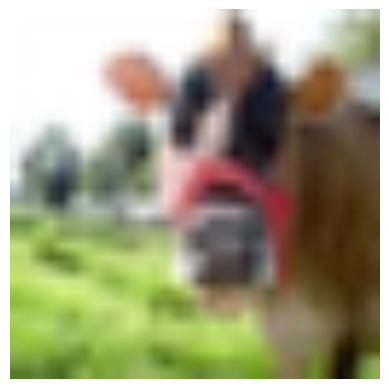

In [23]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Assume `image_tensor` is a tensor of shape (3, H, W), e.g., (3, 32, 32)
def plot_image(image_tensor):
    # Undo normalization if needed (optional step)

    # Convert tensor to NumPy format
    image_np = image_tensor.permute(1, 2, 0).numpy()  # Rearrange to (H, W, C)

    # Clip values to the valid range [0, 1]
    image_np = image_np.clip(0, 1)

    # Plot the image
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example: Plot a single image from CIFAR-100
import torchvision

plot_image(image)


### Nice stuff

In [27]:
chosen_one(image.unsqueeze(0))
chosen_one

vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,

In [43]:
output = chosen_one.save_attn['final']
output = output.squeeze(0)
output.shape

torch.Size([577, 384])

In [44]:
24*24

576

In [45]:
#remove first output element
output = output[1:]
output.shape

torch.Size([576, 384])

In [46]:
# copmute norm of all output elements
output_norms = output.norm(dim=-1)
output_norms.shape

torch.Size([576])

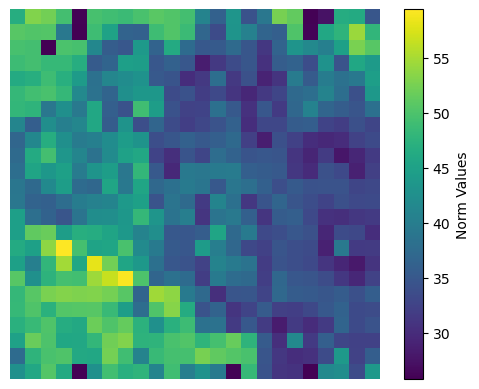

In [47]:
plt.imshow(output_norms.reshape(24, 24).detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.colorbar(label='Norm Values')  # Add a colorbar as a legend
plt.show()

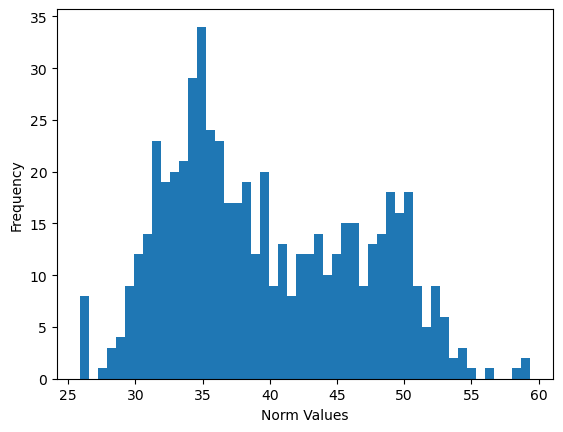

In [48]:
# find histogram of norm values
plt.hist(output_norms.detach().numpy(), bins=50)
plt.xlabel('Norm Values')
plt.ylabel('Frequency')
plt.show()

In [49]:
output = chosen_one.blocks[11].save_block
output = output.squeeze(0)
output.shape

torch.Size([577, 384])

In [50]:
24*24

576

In [51]:
#remove first output element
output = output[1:]
output.shape

torch.Size([576, 384])

In [52]:
# copmute norm of all output elements
output_norms = output.norm(dim=-1)
output_norms.shape

torch.Size([576])

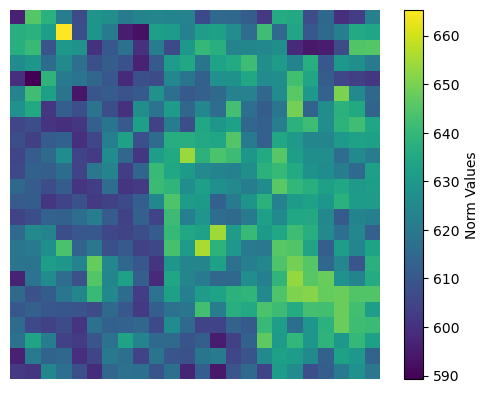

In [53]:
plt.imshow(output_norms.reshape(24, 24).detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.colorbar(label='Norm Values')  # Add a colorbar as a legend
plt.show()

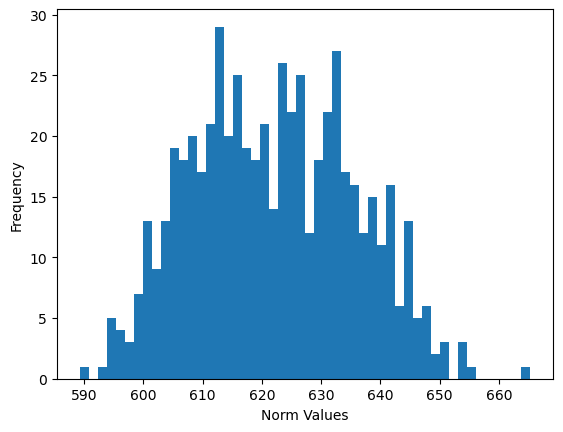

In [54]:
# find histogram of norm values
plt.hist(output_norms.detach().numpy(), bins=50)
plt.xlabel('Norm Values')
plt.ylabel('Frequency')
plt.show()